# Heavy-Tailed Distributions and Risk Measure Comparison

## Quantitative Risk Management - Week 2

This notebook implements:
1. Heavy-tailed distribution theory and simulation
2. VaR vs ES: Properties and coherence
3. Probability shifting under heavy tails
4. Monte Carlo analysis of risk measure relationships

### Theory Overview

**Heavy-Tailed Distribution (Slide 49):**
$$\lim_{t\to\infty} \frac{1-F(tx)}{1-F(t)} = x^{-\alpha}$$

where $\alpha > 0$ is the **tail index**.

**Key Implications:**
- Lower $\alpha$ → Heavier tails
- Moments $E[X^k]$ exist only for $k < \alpha$
- Common in financial returns: $\alpha \in [3, 4]$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize_scalar, brentq
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

## 1. Heavy-Tailed Distributions: Examples and Properties

### Pedagogical Examples (Slide 51)

We implement three distributions:

1. **Pareto Distribution** (exactly heavy-tailed):
   $$F(x) = 1 - \left(\frac{x_m}{x}\right)^\alpha, \quad x \geq x_m$$
   
2. **Student-t Distribution** (heavy-tailed, $\alpha = \nu$):
   - Degrees of freedom $\nu$ = tail index
   - Popular for financial modeling
   
3. **Fréchet Distribution** (heavy-tailed, $\alpha = 1/\gamma$):
   $$F(x) = \exp\left(-x^{-\alpha}\right), \quad x > 0$$

In [2]:
class HeavyTailedDistribution:
    """
    Base class for heavy-tailed distributions.
    """
    
    def __init__(self, alpha):
        self.alpha = alpha
        
    def simulate(self, n, random_state=None):
        raise NotImplementedError
        
    def pdf(self, x):
        raise NotImplementedError
        
    def cdf(self, x):
        raise NotImplementedError
        
    def var(self, p):
        """Value at Risk at confidence level p."""
        raise NotImplementedError
        
    def es(self, p):
        """Expected Shortfall at confidence level p."""
        raise NotImplementedError


class ParetoDistribution(HeavyTailedDistribution):
    """
    Pareto Distribution: F(x) = 1 - (x_m/x)^alpha for x >= x_m.
    
    This is the canonical heavy-tailed distribution.
    """
    
    def __init__(self, alpha, x_m=1.0):
        super().__init__(alpha)
        self.x_m = x_m
        
    def simulate(self, n, random_state=None):
        if random_state is not None:
            np.random.seed(random_state)
        # Inverse transform sampling
        u = np.random.uniform(0, 1, n)
        return self.x_m / (1 - u) ** (1 / self.alpha)
    
    def pdf(self, x):
        return np.where(x >= self.x_m,
                       self.alpha * self.x_m**self.alpha / x**(self.alpha + 1),
                       0)
    
    def cdf(self, x):
        return np.where(x >= self.x_m,
                       1 - (self.x_m / x)**self.alpha,
                       0)
    
    def var(self, p):
        """Analytical VaR for Pareto."""
        return self.x_m / (1 - p) ** (1 / self.alpha)
    
    def es(self, p):
        """Analytical ES for Pareto (slide 55)."""
        if self.alpha <= 1:
            return np.inf
        var_p = self.var(p)
        return self.alpha / (self.alpha - 1) * var_p


class StudentTDistribution(HeavyTailedDistribution):
    """
    Standardized Student-t Distribution.
    
    Tail index alpha = nu (degrees of freedom).
    """
    
    def __init__(self, nu, mu=0, sigma=1):
        super().__init__(alpha=nu)
        self.nu = nu
        self.mu = mu
        self.sigma = sigma
        
    def simulate(self, n, random_state=None):
        if random_state is not None:
            np.random.seed(random_state)
        return self.mu + self.sigma * stats.t.rvs(self.nu, size=n)
    
    def pdf(self, x):
        return stats.t.pdf((x - self.mu) / self.sigma, self.nu) / self.sigma
    
    def cdf(self, x):
        return stats.t.cdf((x - self.mu) / self.sigma, self.nu)
    
    def var(self, p):
        return self.mu + self.sigma * stats.t.ppf(p, self.nu)
    
    def es(self, p):
        """ES for Student-t (numerical integration)."""
        var_p = self.var(p)
        # ES = E[X | X > VaR_p]
        # For Student-t, we use the formula involving the PDF
        z_p = stats.t.ppf(p, self.nu)
        pdf_z = stats.t.pdf(z_p, self.nu)
        
        es = self.mu + self.sigma * (
            pdf_z * (self.nu + z_p**2) / ((1 - p) * (self.nu - 1))
        )
        return es


class FrechetDistribution(HeavyTailedDistribution):
    """
    Fréchet Distribution: F(x) = exp(-x^(-alpha)) for x > 0.
    
    This is the Type II extreme value distribution.
    """
    
    def __init__(self, alpha, mu=0, sigma=1):
        super().__init__(alpha)
        self.mu = mu
        self.sigma = sigma
        
    def simulate(self, n, random_state=None):
        if random_state is not None:
            np.random.seed(random_state)
        u = np.random.uniform(0, 1, n)
        return self.mu + self.sigma * (-np.log(u)) ** (-1/self.alpha)
    
    def pdf(self, x):
        z = (x - self.mu) / self.sigma
        return np.where(z > 0,
                       (self.alpha / self.sigma) * z**(-1-self.alpha) * 
                       np.exp(-z**(-self.alpha)),
                       0)
    
    def cdf(self, x):
        z = (x - self.mu) / self.sigma
        return np.where(z > 0, np.exp(-z**(-self.alpha)), 0)
    
    def var(self, p):
        return self.mu + self.sigma * (-np.log(p)) ** (-1/self.alpha)
    
    def es(self, p):
        """ES for Fréchet (analytical for alpha > 1)."""
        if self.alpha <= 1:
            return np.inf
        var_p = self.var(p)
        # Using asymptotic relationship
        return self.alpha / (self.alpha - 1) * var_p

In [3]:
# Create pedagogical examples with different tail indices
print("="*80)
print("HEAVY-TAILED DISTRIBUTION EXAMPLES")
print("="*80)

# Define distributions with pedagogical tail indices
distributions = {
    'Pareto (α=3)': ParetoDistribution(alpha=3.0, x_m=1.0),
    'Student-t (ν=3)': StudentTDistribution(nu=3.0, mu=0, sigma=1),
    'Pareto (α=4)': ParetoDistribution(alpha=4.0, x_m=1.0),
    'Student-t (ν=4)': StudentTDistribution(nu=4.0, mu=0, sigma=1),
    'Fréchet (α=3)': FrechetDistribution(alpha=3.0, mu=0, sigma=1),
}

# Compare moment existence
print("\nMOMENT EXISTENCE (Slide 56):")
print("-" * 80)
print(f"{'Distribution':<20} {'α':<8} {'E[X]':<10} {'E[X²]':<10} {'E[X³]':<10} {'E[X⁴]':<10}")
print("-" * 80)

for name, dist in distributions.items():
    moments = []
    for k in [1, 2, 3, 4]:
        if k < dist.alpha:
            moments.append("Exists")
        else:
            moments.append("∞")
    print(f"{name:<20} {dist.alpha:<8.1f} {moments[0]:<10} {moments[1]:<10} {moments[2]:<10} {moments[3]:<10}")

print("\nNote: For α=3, variance exists but skewness doesn't!")
print("      For α=4, variance and skewness exist but kurtosis doesn't!")

HEAVY-TAILED DISTRIBUTION EXAMPLES

MOMENT EXISTENCE (Slide 56):
--------------------------------------------------------------------------------
Distribution         α        E[X]       E[X²]      E[X³]      E[X⁴]     
--------------------------------------------------------------------------------
Pareto (α=3)         3.0      Exists     Exists     ∞          ∞         
Student-t (ν=3)      3.0      Exists     Exists     ∞          ∞         
Pareto (α=4)         4.0      Exists     Exists     Exists     ∞         
Student-t (ν=4)      4.0      Exists     Exists     Exists     ∞         
Fréchet (α=3)        3.0      Exists     Exists     ∞          ∞         

Note: For α=3, variance exists but skewness doesn't!
      For α=4, variance and skewness exist but kurtosis doesn't!


### Visualizing Heavy Tails

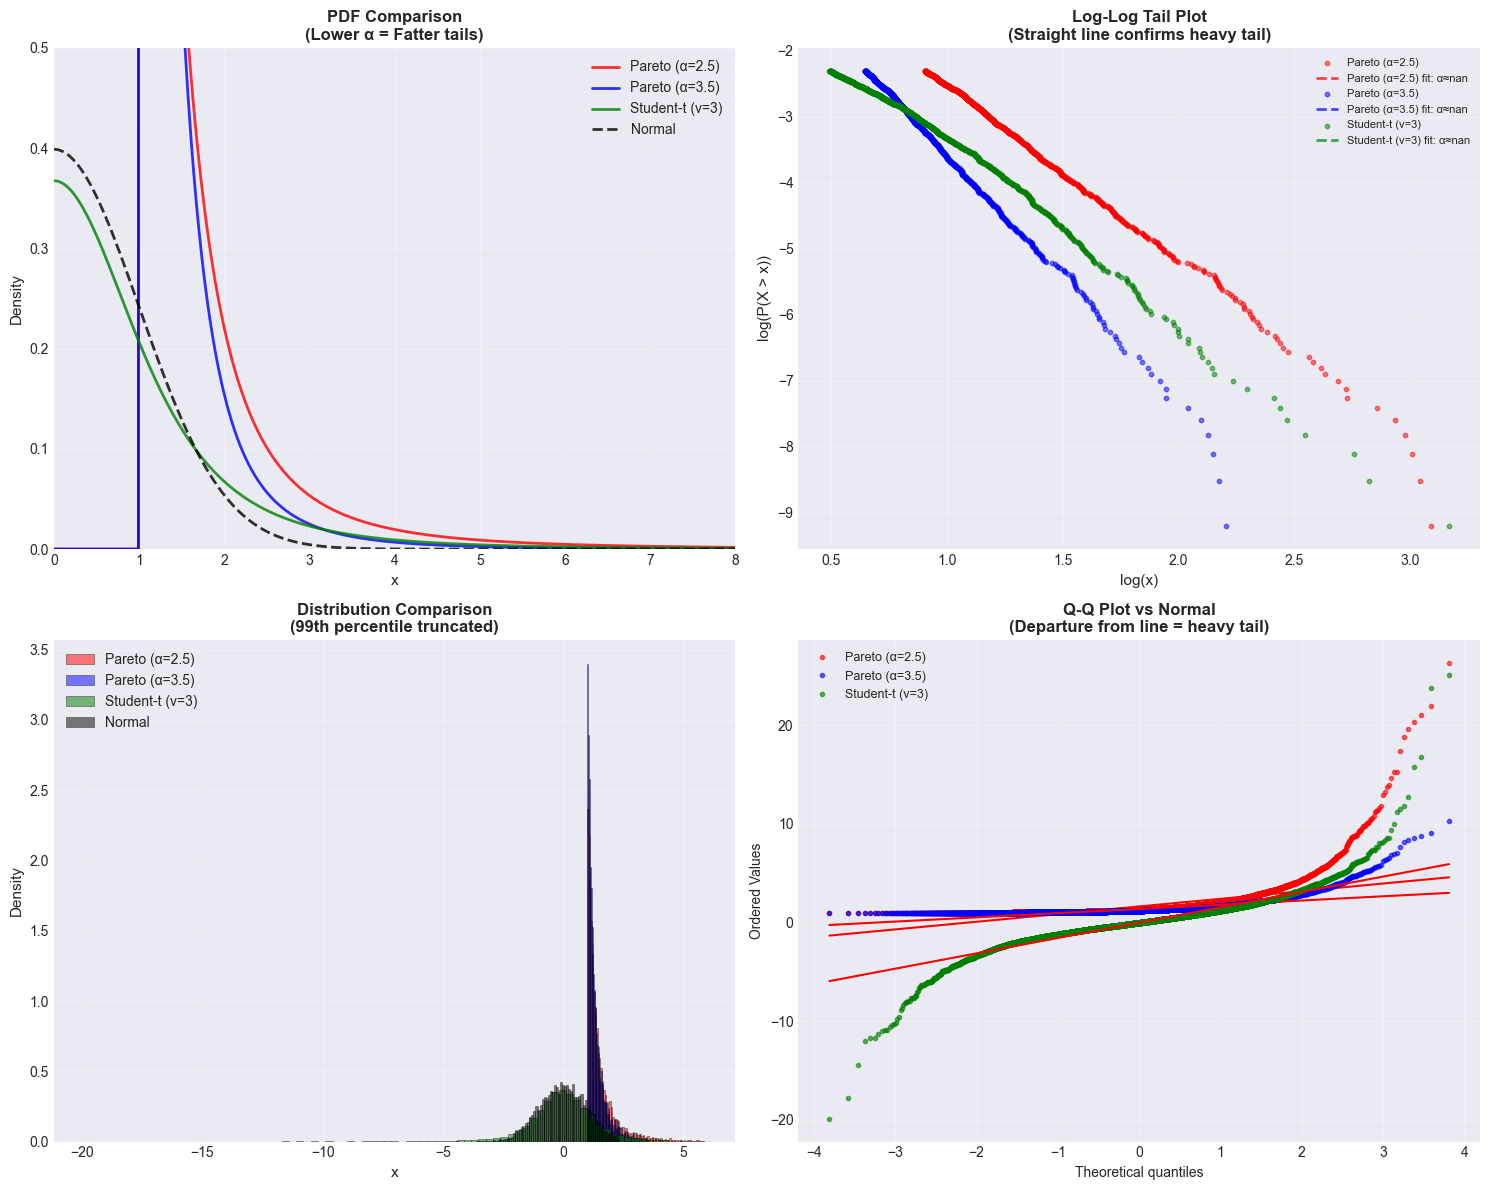

In [4]:
# Simulate and visualize
n_samples = 10000

# Focus on Pareto and Student-t with different alphas
focus_dists = {
    'Pareto (α=2.5)': ParetoDistribution(alpha=2.5, x_m=1.0),
    'Pareto (α=3.5)': ParetoDistribution(alpha=3.5, x_m=1.0),
    'Student-t (ν=3)': StudentTDistribution(nu=3.0, mu=0, sigma=1),
    'Normal': None  # For comparison
}

samples = {}
for name, dist in focus_dists.items():
    if dist is not None:
        samples[name] = dist.simulate(n_samples, random_state=42)
    else:
        samples[name] = np.random.standard_normal(n_samples)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. PDF comparison (zoomed to see differences)
ax = axes[0, 0]
x_range = np.linspace(0, 8, 1000)
colors = ['red', 'blue', 'green', 'black']
for (name, dist), color in zip(focus_dists.items(), colors):
    if dist is not None:
        if isinstance(dist, StudentTDistribution):
            # Shift and scale for comparison
            x_plot = x_range
            y = dist.pdf(x_plot)
        else:
            y = dist.pdf(x_range)
            x_plot = x_range
        ax.plot(x_plot, y, label=name, lw=2, color=color, alpha=0.8)
    else:
        ax.plot(x_range, stats.norm.pdf(x_range), label=name, 
               lw=2, linestyle='--', color=color, alpha=0.8)

ax.set_xlabel('x', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title('PDF Comparison\n(Lower α = Fatter tails)', fontsize=12, fontweight='bold')
ax.legend()
ax.set_xlim([0, 8])
ax.set_ylim([0, 0.5])
ax.grid(True, alpha=0.3)

# 2. Log-log tail plot (Slide 45-46)
ax = axes[0, 1]
for (name, dist), color in zip(focus_dists.items(), colors):
    if name != 'Normal':
        data = samples[name]
        # Create empirical tail: P(X > x)
        sorted_data = np.sort(data)
        tail_prob = 1 - np.arange(1, len(sorted_data)+1) / len(sorted_data)
        
        # Focus on right tail
        threshold = np.percentile(sorted_data, 90)
        mask = sorted_data > threshold
        
        log_x = np.log(sorted_data[mask])
        log_prob = np.log(tail_prob[mask])
        
        ax.scatter(log_x, log_prob, s=10, alpha=0.5, color=color, label=name)
        
        # Fit line: log(1-F(x)) ≈ -alpha*log(x) + const
        if len(log_x) > 10:
            slope, intercept = np.polyfit(log_x, log_prob, 1)
            ax.plot(log_x, slope*log_x + intercept, '--', 
                   color=color, lw=2, alpha=0.7,
                   label=f'{name} fit: α≈{-slope:.2f}')

ax.set_xlabel('log(x)', fontsize=11)
ax.set_ylabel('log(P(X > x))', fontsize=11)
ax.set_title('Log-Log Tail Plot\n(Straight line confirms heavy tail)', 
            fontsize=12, fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# 3. Histograms
ax = axes[1, 0]
for (name, _), color in zip(focus_dists.items(), colors):
    # Truncate extreme values for visibility
    data_plot = samples[name]
    data_plot = data_plot[data_plot < np.percentile(data_plot, 99)]
    ax.hist(data_plot, bins=80, alpha=0.5, density=True, 
           label=name, color=color, edgecolor='black', linewidth=0.5)

ax.set_xlabel('x', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title('Distribution Comparison\n(99th percentile truncated)', 
            fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Q-Q plots against normal
ax = axes[1, 1]
for (name, _), color in zip(focus_dists.items(), colors):
    if name != 'Normal':
        stats.probplot(samples[name], dist="norm", plot=ax)
        ax.get_lines()[-2].set_color(color)
        ax.get_lines()[-2].set_label(name)
        ax.get_lines()[-2].set_markersize(3)
        ax.get_lines()[-2].set_alpha(0.6)

ax.set_title('Q-Q Plot vs Normal\n(Departure from line = heavy tail)', 
            fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('heavy_tail_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

## 2. Coherent Risk Measures: VaR vs ES

### Coherency Axioms (Slide 3)

A risk measure $\rho$ is **coherent** if it satisfies:

1. **Monotonicity**: If $X \leq Y$, then $\rho(X) \leq \rho(Y)$
2. **Translation Invariance**: $\rho(X + c) = \rho(X) + c$ for constant $c$
3. **Positive Homogeneity**: $\rho(\lambda X) = \lambda \rho(X)$ for $\lambda > 0$
4. **Subadditivity**: $\rho(X + Y) \leq \rho(X) + \rho(Y)$

**Result (Slides 4-7):**
- **VaR**: NOT coherent (fails subadditivity)
- **ES**: Coherent (satisfies all axioms)

### Counterexample: VaR Subadditivity Failure (Slide 4)

In [5]:
def demonstrate_var_subadditivity_failure():
    """
    Recreate the bond example from slide 4.
    
    Two identical bonds:
    - Price: 100
    - Payoff: 105 with prob (1-p), 0 with prob p
    - Loss: -5 with prob (1-p), 100 with prob p
    """
    p = 0.05  # Default probability
    
    # Choose alpha such that (1-p)^2 < alpha < 1-p
    # This ensures: P(L1 > -5) > 1-alpha > P(L1+L2 > -10)
    alpha = 0.92  # Between (1-p)^2 = 0.9025 and 1-p = 0.95
    
    print("="*80)
    print("VaR SUBADDITIVITY FAILURE: Bond Example (Slide 4)")
    print("="*80)
    print(f"\nSetup:")
    print(f"  Default probability p = {p:.2%}")
    print(f"  Confidence level α = {alpha:.2%}")
    print(f"  Condition: (1-p)² = {(1-p)**2:.4f} < α < 1-p = {1-p:.4f}")
    
    # Individual bond losses
    # L1 = L2: -5 with prob (1-p), 100 with prob p
    # P(L > -5) = p = 0.05 < 1-α = 0.08
    # Therefore VaR_α(L1) = -5
    var_l1 = -5
    var_l2 = -5
    
    # Combined portfolio L = L1 + L2
    # L = -10 with prob (1-p)^2 = 0.9025
    # L = 95 with prob 2p(1-p) = 0.095
    # L = 200 with prob p^2 = 0.0025
    
    # P(L > 95) = p^2 = 0.0025 < 1-α = 0.08
    # P(L > -10) = 2p(1-p) + p^2 = 0.0975 > 1-α = 0.08
    # Therefore VaR_α(L) = 95
    var_combined = 95
    
    print(f"\nResults:")
    print(f"  VaR_{alpha:.0%}(L₁) = {var_l1}")
    print(f"  VaR_{alpha:.0%}(L₂) = {var_l2}")
    print(f"  VaR_{alpha:.0%}(L₁ + L₂) = {var_combined}")
    print(f"\nSubadditivity check:")
    print(f"  VaR(L₁ + L₂) = {var_combined}")
    print(f"  VaR(L₁) + VaR(L₂) = {var_l1 + var_l2}")
    print(f"  Violation: {var_combined} > {var_l1 + var_l2}!")
    print(f"\n  ⚠️  VaR is NOT SUBADDITIVE!")
    print(f"      Diversification can INCREASE VaR.")
    
    # Monte Carlo verification
    print(f"\n" + "="*80)
    print("Monte Carlo Verification")
    print("="*80)
    
    n_sim = 100000
    np.random.seed(42)
    
    # Simulate defaults (independent)
    default1 = np.random.binomial(1, p, n_sim)
    default2 = np.random.binomial(1, p, n_sim)
    
    # Calculate losses
    L1 = np.where(default1 == 1, 100, -5)
    L2 = np.where(default2 == 1, 100, -5)
    L_combined = L1 + L2
    
    # Calculate VaR
    var_l1_mc = np.percentile(L1, alpha * 100)
    var_l2_mc = np.percentile(L2, alpha * 100)
    var_combined_mc = np.percentile(L_combined, alpha * 100)
    
    print(f"\nMonte Carlo estimates (n={n_sim:,}):")
    print(f"  VaR_{alpha:.0%}(L₁) ≈ {var_l1_mc:.2f}")
    print(f"  VaR_{alpha:.0%}(L₂) ≈ {var_l2_mc:.2f}")
    print(f"  VaR_{alpha:.0%}(L₁ + L₂) ≈ {var_combined_mc:.2f}")
    print(f"  Sum: {var_l1_mc + var_l2_mc:.2f}")
    print(f"  Violation: {var_combined_mc:.2f} > {var_l1_mc + var_l2_mc:.2f}")
    
    return L1, L2, L_combined

L1, L2, L_combined = demonstrate_var_subadditivity_failure()

VaR SUBADDITIVITY FAILURE: Bond Example (Slide 4)

Setup:
  Default probability p = 5.00%
  Confidence level α = 92.00%
  Condition: (1-p)² = 0.9025 < α < 1-p = 0.9500

Results:
  VaR_92%(L₁) = -5
  VaR_92%(L₂) = -5
  VaR_92%(L₁ + L₂) = 95

Subadditivity check:
  VaR(L₁ + L₂) = 95
  VaR(L₁) + VaR(L₂) = -10
  Violation: 95 > -10!

  ⚠️  VaR is NOT SUBADDITIVE!
      Diversification can INCREASE VaR.

Monte Carlo Verification

Monte Carlo estimates (n=100,000):
  VaR_92%(L₁) ≈ -5.00
  VaR_92%(L₂) ≈ -5.00
  VaR_92%(L₁ + L₂) ≈ 95.00
  Sum: -10.00
  Violation: 95.00 > -10.00


## 3. VaR and ES under Heavy Tails

### Probability Shifting (Slide 54)

For heavy-tailed distributions with tail index $\alpha$:

$$\lim_{p\to 1} \frac{\text{VaR}_p}{\text{VaR}_q} = \left(\frac{1-q}{1-p}\right)^{1/\alpha}$$

### ES-VaR Relationship (Slide 55)

For $\alpha > 1$:
$$\lim_{p\to 1} \frac{\text{ES}_p}{\text{VaR}_p} = \frac{\alpha}{\alpha - 1}$$

**Implications:**
- Lower $\alpha$ → Larger ES/VaR ratio
- For $\alpha = 3$: ES ≈ 1.5 × VaR
- For $\alpha = 4$: ES ≈ 1.33 × VaR

In [6]:
def analyze_probability_shifting(dist, alphas_to_test, q=0.95, sample_size=100000):
    """
    Verify probability shifting relationship (slide 54).
    
    Tests: VaR_p / VaR_q ≈ ((1-q)/(1-p))^(1/alpha)
    """
    print("="*80)
    print(f"PROBABILITY SHIFTING ANALYSIS (Slide 54)")
    print("="*80)
    print(f"\nBase confidence level q = {q:.0%}")
    print(f"Sample size = {sample_size:,}\n")
    
    results = []
    
    for alpha in alphas_to_test:
        print(f"\nTail Index α = {alpha:.1f}")
        print("-" * 80)
        
        # Create distribution
        if isinstance(dist, str) and dist == 'pareto':
            model = ParetoDistribution(alpha=alpha, x_m=1.0)
        elif isinstance(dist, str) and dist == 'student_t':
            model = StudentTDistribution(nu=alpha, mu=0, sigma=1)
        else:
            model = dist
        
        # Simulate
        data = model.simulate(sample_size, random_state=42)
        
        # Calculate VaR at different levels
        var_q = np.percentile(data, q * 100)
        
        # Test probability shifting for various p > q
        test_ps = [0.975, 0.99, 0.995, 0.999]
        
        print(f"{'p':<8} {'VaR_p':<12} {'Ratio':<12} {'Theory':<12} {'Error %':<12}")
        print("-" * 80)
        
        for p in test_ps:
            if p > q:
                var_p = np.percentile(data, p * 100)
                empirical_ratio = var_p / var_q
                theoretical_ratio = ((1-q)/(1-p)) ** (1/alpha)
                error_pct = (empirical_ratio - theoretical_ratio) / theoretical_ratio * 100
                
                print(f"{p:<8.1%} {var_p:<12.4f} {empirical_ratio:<12.4f} "
                     f"{theoretical_ratio:<12.4f} {error_pct:<12.2f}")
                
                results.append({
                    'alpha': alpha,
                    'p': p,
                    'empirical': empirical_ratio,
                    'theoretical': theoretical_ratio
                })
    
    return pd.DataFrame(results)

# Test for different tail indices
shifting_results = analyze_probability_shifting('pareto', [2.5, 3.0, 3.5, 4.0], q=0.95)

PROBABILITY SHIFTING ANALYSIS (Slide 54)

Base confidence level q = 95%
Sample size = 100,000


Tail Index α = 2.5
--------------------------------------------------------------------------------
p        VaR_p        Ratio        Theory       Error %     
--------------------------------------------------------------------------------
97.5%    4.3184       1.3157       1.3195       -0.29       
99.0%    6.2484       1.9037       1.9037       0.00        
99.5%    8.1670       2.4882       2.5119       -0.94       
99.9%    14.9604      4.5580       4.7818       -4.68       

Tail Index α = 3.0
--------------------------------------------------------------------------------
p        VaR_p        Ratio        Theory       Error %     
--------------------------------------------------------------------------------
97.5%    3.3840       1.2569       1.2599       -0.24       
99.0%    4.6041       1.7100       1.7100       0.00        
99.5%    5.7551       2.1375       2.1544       -0.79

In [7]:
def analyze_es_var_relationship(alphas, sample_size=100000):
    """
    Verify ES/VaR relationship (slide 55).
    
    Tests: ES_p / VaR_p → alpha/(alpha-1) as p → 1
    """
    print("\n" + "="*80)
    print("ES/VaR RELATIONSHIP ANALYSIS (Slide 55)")
    print("="*80)
    print(f"Sample size = {sample_size:,}\n")
    
    confidence_levels = [0.90, 0.95, 0.975, 0.99, 0.995, 0.999]
    
    results_list = []
    
    for alpha in alphas:
        print(f"\nTail Index α = {alpha:.1f}")
        print(f"Theoretical limit: ES/VaR → {alpha/(alpha-1):.4f}")
        print("-" * 80)
        
        # Pareto distribution
        dist = ParetoDistribution(alpha=alpha, x_m=1.0)
        data = dist.simulate(sample_size, random_state=42)
        
        print(f"{'Confidence':<12} {'VaR':<12} {'ES':<12} {'ES/VaR':<12} {'Theory':<12} {'Error %':<12}")
        print("-" * 80)
        
        for p in confidence_levels:
            # Monte Carlo VaR and ES
            var_p = np.percentile(data, p * 100)
            tail_data = data[data >= var_p]
            es_p = tail_data.mean() if len(tail_data) > 0 else var_p
            
            ratio = es_p / var_p
            theory = alpha / (alpha - 1)
            error_pct = (ratio - theory) / theory * 100
            
            print(f"{p:<12.1%} {var_p:<12.4f} {es_p:<12.4f} {ratio:<12.4f} "
                 f"{theory:<12.4f} {error_pct:<12.2f}")
            
            results_list.append({
                'alpha': alpha,
                'confidence': p,
                'VaR': var_p,
                'ES': es_p,
                'ratio': ratio,
                'theory': theory
            })
    
    return pd.DataFrame(results_list)

# Test for typical financial market tail indices
es_var_results = analyze_es_var_relationship([2.5, 3.0, 3.5, 4.0], sample_size=100000)


ES/VaR RELATIONSHIP ANALYSIS (Slide 55)
Sample size = 100,000


Tail Index α = 2.5
Theoretical limit: ES/VaR → 1.6667
--------------------------------------------------------------------------------
Confidence   VaR          ES           ES/VaR       Theory       Error %     
--------------------------------------------------------------------------------
90.0%        2.4942       4.1338       1.6573       1.6667       -0.56       
95.0%        3.2822       5.4410       1.6577       1.6667       -0.54       
97.5%        4.3184       7.1670       1.6597       1.6667       -0.42       
99.0%        6.2484       10.2745      1.6443       1.6667       -1.34       
99.5%        8.1670       13.5132      1.6546       1.6667       -0.72       
99.9%        14.9604      25.1005      1.6778       1.6667       0.67        

Tail Index α = 3.0
Theoretical limit: ES/VaR → 1.5000
--------------------------------------------------------------------------------
Confidence   VaR          ES         

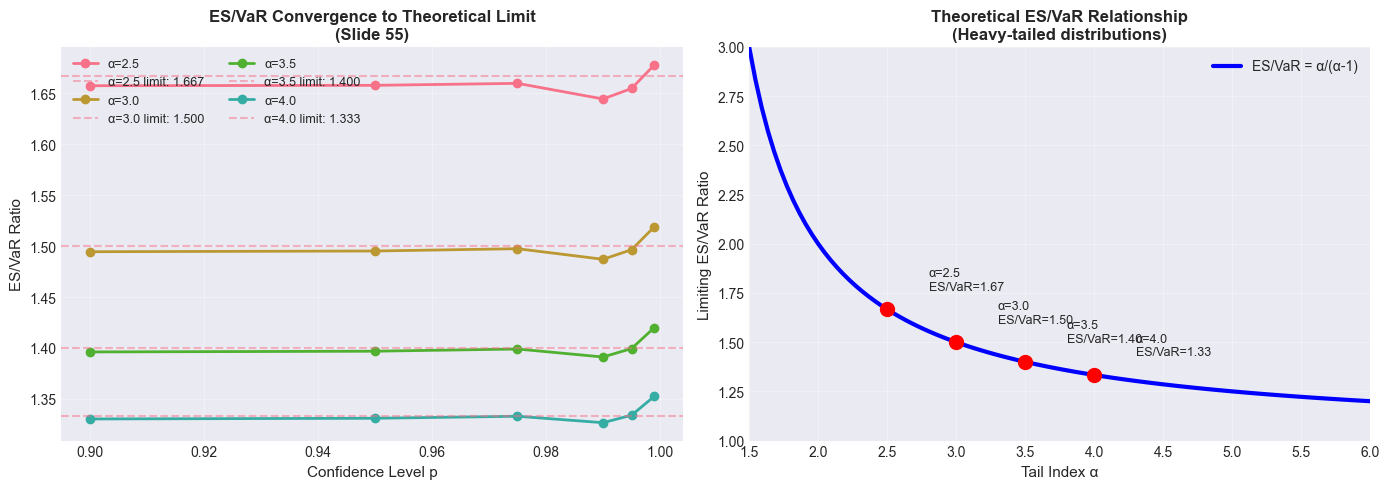


KEY INSIGHT:
For heavy-tailed distributions (typical α ∈ [3, 4] for finance):
  • ES is 25-50% larger than VaR
  • Lower α (fatter tails) → larger ES/VaR gap
  • Convergence is faster at higher confidence levels (p → 1)
  • Emerging markets often have α ∈ [2.5, 3.5] → even larger gap!


In [8]:
# Visualize ES/VaR convergence
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: ES/VaR ratio vs confidence level
ax = axes[0]
for alpha in [2.5, 3.0, 3.5, 4.0]:
    data = es_var_results[es_var_results['alpha'] == alpha]
    ax.plot(data['confidence'], data['ratio'], 'o-', label=f'α={alpha:.1f}', 
           lw=2, markersize=6)
    
    # Theoretical limit
    theory = alpha / (alpha - 1)
    ax.axhline(theory, linestyle='--', alpha=0.5, lw=1.5,
              label=f'α={alpha:.1f} limit: {theory:.3f}')

ax.set_xlabel('Confidence Level p', fontsize=11)
ax.set_ylabel('ES/VaR Ratio', fontsize=11)
ax.set_title('ES/VaR Convergence to Theoretical Limit\n(Slide 55)',
            fontsize=12, fontweight='bold')
ax.legend(fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)

# Plot 2: Theoretical relationship
ax = axes[1]
alpha_range = np.linspace(1.5, 6, 100)
es_var_limit = alpha_range / (alpha_range - 1)
ax.plot(alpha_range, es_var_limit, 'b-', lw=3, label='ES/VaR = α/(α-1)')

# Mark typical values
for alpha in [2.5, 3.0, 3.5, 4.0]:
    limit = alpha / (alpha - 1)
    ax.plot(alpha, limit, 'ro', markersize=10)
    ax.annotate(f'α={alpha:.1f}\nES/VaR={limit:.2f}', 
               xy=(alpha, limit), xytext=(alpha+0.3, limit+0.1),
               fontsize=9, ha='left')

ax.set_xlabel('Tail Index α', fontsize=11)
ax.set_ylabel('Limiting ES/VaR Ratio', fontsize=11)
ax.set_title('Theoretical ES/VaR Relationship\n(Heavy-tailed distributions)',
            fontsize=12, fontweight='bold')
ax.set_xlim([1.5, 6])
ax.set_ylim([1, 3])
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('es_var_relationship.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("KEY INSIGHT:")
print("="*80)
print("For heavy-tailed distributions (typical α ∈ [3, 4] for finance):")
print("  • ES is 25-50% larger than VaR")
print("  • Lower α (fatter tails) → larger ES/VaR gap")
print("  • Convergence is faster at higher confidence levels (p → 1)")
print("  • Emerging markets often have α ∈ [2.5, 3.5] → even larger gap!")

## 4. Basel III Regulatory Change Analysis

### Problem Setup (Slide 72, Exercise 2)

Basel III changed market risk capital requirement from:
- **Basel II**: VaR₉₉%
- **Basel III**: ES₉₇.₅%

**Question**: How does this affect required capital?

Given:
- $(1-p)/(1-q) = 2.5$ where $p = 0.99$, $q = 0.975$
- Typical tail indices: $\alpha \in [3, 4]$

In [9]:
def basel_capital_analysis():
    """
    Analyze Basel II → Basel III capital change.
    
    From slide 72, Exercise 2.
    """
    print("="*80)
    print("BASEL II → BASEL III CAPITAL REQUIREMENT ANALYSIS")
    print("="*80)
    
    p = 0.99   # Basel II
    q = 0.975  # Basel III
    
    print(f"\nRegulatory Change:")
    print(f"  Basel II: VaR₉₉%")
    print(f"  Basel III: ES₉₇.₅%")
    print(f"\nProbability ratio: (1-q)/(1-p) = {(1-q)/(1-p):.2f}")
    
    # Test different tail indices
    alphas = [2.5, 3.0, 3.5, 4.0]
    
    print("\n" + "="*80)
    print("ANALYTICAL RESULTS (Slides 54-55):")
    print("="*80)
    print(f"\n{'α':<8} {'VaR_p/VaR_q':<15} {'ES_p/VaR_p':<15} {'ES_p/VaR_q':<15} {'Capital Change':<15}")
    print("-" * 80)
    
    for alpha in alphas:
        # Step 1: VaR_p / VaR_q (probability shifting, slide 54)
        var_ratio = ((1-q)/(1-p)) ** (1/alpha)
        
        # Step 2: ES_p / VaR_p (slide 55)
        if alpha > 1:
            es_var_ratio = alpha / (alpha - 1)
        else:
            es_var_ratio = np.inf
        
        # Step 3: ES_p / VaR_q
        total_ratio = es_var_ratio * var_ratio
        
        # Capital change
        capital_change_pct = (total_ratio - 1) * 100
        
        print(f"{alpha:<8.1f} {var_ratio:<15.4f} {es_var_ratio:<15.4f} "
             f"{total_ratio:<15.4f} {capital_change_pct:>+14.2f}%")
    
    print("\n" + "="*80)
    print("MONTE CARLO VERIFICATION:")
    print("="*80)
    
    n_sim = 200000
    
    for alpha in alphas:
        print(f"\nα = {alpha:.1f}:")
        print("-" * 40)
        
        # Generate data
        dist = ParetoDistribution(alpha=alpha, x_m=1.0)
        data = dist.simulate(n_sim, random_state=42)
        
        # Basel II: VaR 99%
        var_basel2 = np.percentile(data, p * 100)
        
        # Basel III: ES 97.5%
        var_975 = np.percentile(data, q * 100)
        tail_data = data[data >= var_975]
        es_basel3 = tail_data.mean()
        
        ratio_mc = es_basel3 / var_basel2
        change_mc = (ratio_mc - 1) * 100
        
        print(f"  VaR₉₉% (Basel II):   {var_basel2:.4f}")
        print(f"  ES₉₇.₅% (Basel III):  {es_basel3:.4f}")
        print(f"  Ratio:               {ratio_mc:.4f}")
        print(f"  Capital change:      {change_mc:+.2f}%")
    
    return

basel_capital_analysis()

print("\n" + "="*80)
print("REGULATORY IMPLICATIONS:")
print("="*80)
print("\n1. Banks must hold 6-13% MORE capital under Basel III")
print("   (depending on tail heaviness)")
print("\n2. Heavier tails (lower α) → larger capital increase")
print("   - Emerging markets (α ≈ 2.5-3): ~10-13% increase")
print("   - Developed markets (α ≈ 3.5-4): ~6-8% increase")
print("\n3. This addresses VaR's coherence failure")
print("   - ES accounts for tail losses beyond VaR")
print("   - No 'diversification paradox'")
print("\n4. Tradeoff: More conservative but harder to backtest")

BASEL II → BASEL III CAPITAL REQUIREMENT ANALYSIS

Regulatory Change:
  Basel II: VaR₉₉%
  Basel III: ES₉₇.₅%

Probability ratio: (1-q)/(1-p) = 2.50

ANALYTICAL RESULTS (Slides 54-55):

α        VaR_p/VaR_q     ES_p/VaR_p      ES_p/VaR_q      Capital Change 
--------------------------------------------------------------------------------
2.5      1.4427          1.6667          2.4045                 +140.45%
3.0      1.3572          1.5000          2.0358                 +103.58%
3.5      1.2993          1.4000          1.8190                  +81.90%
4.0      1.2574          1.3333          1.6766                  +67.66%

MONTE CARLO VERIFICATION:

α = 2.5:
----------------------------------------
  VaR₉₉% (Basel II):   6.2903
  ES₉₇.₅% (Basel III):  7.2401
  Ratio:               1.1510
  Capital change:      +15.10%

α = 3.0:
----------------------------------------
  VaR₉₉% (Basel II):   4.6298
  ES₉₇.₅% (Basel III):  5.1103
  Ratio:               1.1038
  Capital change:      +10

## 5. Summary and Key Takeaways

### Heavy-Tailed Distributions
- **Definition**: $\lim_{t\to\infty} \frac{1-F(tx)}{1-F(t)} = x^{-\alpha}$
- **Tail index** $\alpha$ determines:
  - Moment existence: $E[X^k]$ finite only for $k < \alpha$
  - Tail decay rate: lower $\alpha$ = slower decay = fatter tails
- **Financial applications**: Typical $\alpha \in [2.5, 4]$

### VaR vs ES
- **VaR**: Simple quantile, NOT coherent (fails subadditivity)
  - Can discourage diversification!
  - Ignores tail shape beyond threshold
  
- **ES**: Coherent, accounts for tail severity
  - Harder to estimate and backtest
  - Better for extreme risk management

### Probability Shifting
$$\text{VaR}_p \approx \text{VaR}_q \left(\frac{1-q}{1-p}\right)^{1/\alpha}$$

### ES-VaR Relationship
$$\text{ES}_p \approx \frac{\alpha}{\alpha-1} \text{VaR}_p$$

### Basel III Implications
- ES₉₇.₅% requires 6-13% more capital than VaR₉₉%
- Change magnitude depends on tail index
- Addresses coherence concerns

## 6. Exercises

### Exercise 1: Custom Heavy-Tailed Distribution
Create a mixture of Pareto distributions with different tail indices. How does this affect:
- The effective tail index?
- ES/VaR ratio?
- Probability shifting accuracy?

### Exercise 2: Emerging Market Application
Use emerging market equity data to:
1. Estimate tail index using Hill estimator (see next notebook)
2. Calculate VaR₉₉% and ES₉₇.₅%
3. Compare with Basel regulatory capital

### Exercise 3: Coherence Verification
Implement numerical tests for all four coherence axioms for:
- VaR
- ES
- Standard deviation

### Exercise 4: Sensitivity Analysis
How sensitive are the Basel capital calculations to:
- Tail index estimation error?
- Sample size?
- Extreme observations?